In [1]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# 1. Dataset
- Train English -> French dictionary

## 1.1 Data
#### Load Embeddings

In [2]:
en_embeddings = pickle.load(open('datasets/en_embeddings.p', 'rb'))
fr_embeddings = pickle.load(open('datasets/fr_embeddings.p', 'rb'))

print(len(en_embeddings))
print(len(fr_embeddings))
print()
print(en_embeddings['the'].shape)
print(fr_embeddings['la'].shape)

# View
print()
for i, key in enumerate(en_embeddings):
    print(key, ':', en_embeddings[key][:5])
    if i == 5: break

print()
for i, key in enumerate(fr_embeddings):
    print(key, ':', fr_embeddings[key][:5])
    if i == 5: break

6370
5766

(300,)
(300,)

the : [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281]
was : [ 0.02600098 -0.00189209  0.18554688 -0.05175781  0.00512695]
for : [-0.01177979 -0.04736328  0.04467773  0.06347656 -0.01818848]
that : [-0.01574707 -0.02832031  0.08349609  0.05029297 -0.11035156]
with : [-0.02490234  0.02197266 -0.03540039  0.13671875  0.01635742]
from : [ 0.05810547 -0.00017452  0.07617188  0.05322266  0.02514648]

la : [-0.0061825  -0.00094387 -0.00882648  0.0324623  -0.0218281 ]
était : [-0.0341354  0.042414  -0.0656882  0.0563061  0.0743264]
pour : [ 0.0426481   0.0395683  -0.00825683 -0.0214458  -0.0976271 ]
cela : [-0.0662544  -0.0448791  -0.034903    0.0451009  -0.00433476]
avec : [-0.0279761  0.0359985 -0.0309898  0.125742  -0.0408834]
depuis : [-0.0174121 -0.0528022 -0.0012797  0.0361534 -0.0464965]


#### Train - Test dictionary

In [3]:
def get_dict(file_name):
    my_file = pd.read_csv(file_name, delimiter=' ')
    etof = {}  # the english to french dictionary to be returned
    for i in range(len(my_file)):
        en = my_file.loc[i][0]
        fr = my_file.loc[i][1]
        etof[en] = fr
    return etof

In [4]:
en_fr_train = get_dict('datasets/en-fr.train.txt')
en_fr_test = get_dict('datasets/en-fr.test.txt')

print(len(en_fr_train))
print(len(en_fr_test))

# View
print()
for i, key in enumerate(en_fr_train):
    print(key, '->', en_fr_train[key])
    if i == 5: break
print()
for i, key in enumerate(en_fr_test):
    print(key, '->', en_fr_test[key])
    if i == 5: break

5000
1500

the -> la
and -> et
was -> était
for -> pour
that -> cela
with -> avec

torpedo -> torpilles
giovanni -> giovanni
chat -> chat
catholics -> catholiques
herald -> herald
chuck -> chuck


## 1.2 Feature Engineering
#### Generate embedding matrix
<img src="./assets/X_to_Y.jpg" width="780"/>


In [5]:
def generate_XY(en_fr, french_vecs, english_vecs):
    """
    Input:
        en_fr (dict(str) -> str) : English to French dictionary
        french_vecs (dict(str) -> ndarray) : French words to their corresponding word embeddings.
        english_vecs (dict(str) -> ndarray) : English words to their corresponding word embeddings.
    Output: 
        X (ndarray (m,n)) : m English embeddings, n = embedding dim size
        Y (ndarray (m,n)) : m French embeddings, n = embedding dim size
        en_vocabs (list(str) size m) : list of english words in X
        fr_vocabs (list(str) size m) : list of french words in Y
    """
    X = []
    Y = []
    en_vocabs = []
    fr_vocabs= []

    # English, French words in embeddings
    english_set = english_vecs.keys()
    french_set = french_vecs.keys()

    for en_word, fr_word in en_fr.items():
        if en_word in english_set and fr_word in french_set:
            en_vec = english_vecs[en_word]
            fr_vec = french_vecs[fr_word]

            X.append(en_vec)
            Y.append(fr_vec)
            
            en_vocabs.append(en_word)
            fr_vocabs.append(fr_word)

    return np.vstack(X), np.vstack(Y), en_vocabs, fr_vocabs

In [6]:
X_train, Y_train, _, _ = generate_XY(
    en_fr_train, fr_embeddings, en_embeddings)

print(X_train.shape)
print(Y_train.shape)

(4932, 300)
(4932, 300)


# 2. Model Training
## 2.1 Linear transformation

$$\hat{Y} = X\cdot R$$
- $X$: Input English embeddings
- $\hat{Y}$: Output French Embedding
- $R$: parameter, transform matrix

In [7]:
def f(X, R):
    '''
    Inputs: 
        X (ndarray (m,n)) : m English embeddings, n = embedding dim size
        R (ndarray (n,n)) : transformation matrix from English to French vector space
    Outputs:
        Y_hat (ndarray (m,n)) : m predicted French embeddings, n = embedding dim size
    '''
    return np.dot(X, R)

## 2.2 Cost function
#### Frobenius normalization
- **Frobenius normalization** of matrix A = square root of the sum of the absolute squares of  A's elements

$$||A||_F = \sqrt{\sum\limits_{i=1}^m\sum\limits_{j=1}^n |a_{ij}|^2 }$$

#### Cost function: Frobenius norm square

$$\begin{split}
    J(R) &= \frac{1}{m} ||\hat{Y} - Y||_F^2 \\
        &= \frac{1}{m} ||X\cdot R - Y||_F^2 \\
        &= \frac{1}{m} ||\hat{Y} - Y||_F^2
\end{split}$$

- $m$: dataset size
- $n$: Embedding vector dim size (feat size)

In [8]:
def compute_cost(X, Y, R):
    '''
    Inputs: 
        X (ndarray (m,n)) : m English embeddings, n = embedding dim size
        Y (ndarray (m,n)) : m French embeddings, n = embedding dim size
        R (ndarray (n,n)) : transformation matrix from English to French vector space
    Outputs:
        cost (scalar): cost
    '''
    m = X.shape[0]
    
    Y_hat = f(X, R)
    return 1./m * np.sum(np.power(Y_hat - Y, 2))

## 2.3 Gradient

#### Gradient of cost function
$$\begin{split}
\frac{\partial J(R)}{\partial R}  &= \frac{\frac{1}{m} ||X\cdot R - Y||_F^2}{\partial R} \\
     &= \frac{2}{m} X^T (X\cdot R - Y) \\
     &= \frac{2}{m} X^T (\hat{Y} - Y) \\
\end{split}$$

#### Update R
+ $\alpha$: Learning rate

$\begin{split}
\text{repeat until convergence: } \\
R &= R -  \alpha \frac{\partial J(R)}{\partial R} 
\end{split}$

In [9]:
def compute_gradient(X, Y, R):
    '''
    Inputs: 
        X (ndarray (m,n)) : m English embeddings, n = embedding dim size
        Y (ndarray (m,n)) : m French embeddings, n = embedding dim size
        R (ndarray (n,n)) : transformation matrix from English to French vector space
    Outputs:
        dJ_dR (ndarray (n,n)) : gradient of the cost function
    '''
    m = X.shape[0]
    
    Y_hat = f(X, R)
    return 1./m * np.dot(X.T, Y_hat - Y)

## 2.4 Train

In [10]:
def fit(X, Y,
        num_iters=100, alpha=0.0003):
    '''
    Inputs:
        X (ndarray (m,n)) : m English embeddings, n = embedding dim size
        Y (ndarray (m,n)) : m French embeddings, n = embedding dim size
        num_iters (int)   : number of iterations to run gradient descent
        alpha (float)     : Learning rate
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||X R -Y||^2
    '''
    m, n = X.shape

    # cost history
    J_history = []

    # Init R
    R = np.random.rand(n, n)
    for i in range(num_iters):

        # Calculate the gradient
        dJ_dR = compute_gradient(X, Y, R)

        # Update R
        R -= alpha * dJ_dR

        # Save cost J at each iteration
        cost = compute_cost(X, Y, R)
        if i<100000:
            J_history.append( cost )

        # Print
        if i % 100 == 0 or i == num_iters-1:
            print(f"Cost after iteration {i}: {cost:.4f}")
    return R, J_history

In [11]:
np.random.seed(129)
R, J_hist = fit(X_train, Y_train, num_iters=1000, alpha=0.8)

Cost after iteration 0: 783.4176
Cost after iteration 100: 26.6473
Cost after iteration 200: 4.3753
Cost after iteration 300: 1.4495
Cost after iteration 400: 0.8259
Cost after iteration 500: 0.6538
Cost after iteration 600: 0.5982
Cost after iteration 700: 0.5783
Cost after iteration 800: 0.5706
Cost after iteration 900: 0.5673
Cost after iteration 999: 0.5659


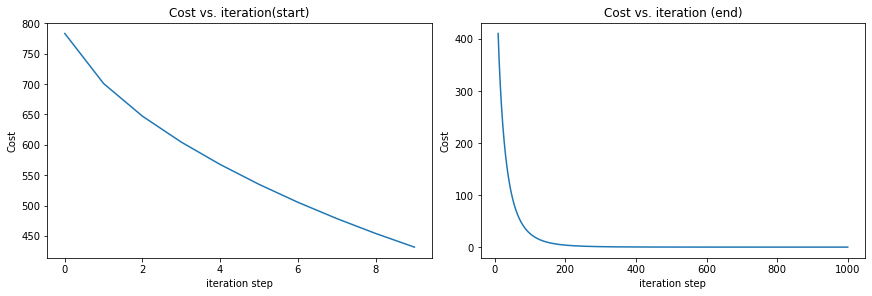

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

ax1.plot(J_hist[:10])
ax2.plot(10 + np.arange(len(J_hist[10:])), J_hist[10:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

# 3. Inference

In [13]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine distance between A and B.
    '''
    return np.dot(A, B) / (np.linalg.norm(A)*np.linalg.norm(B))

In [14]:
def get_k_nearest(v, candidates, k=1):
    """
    Input:
        v (ndarray (n,)) : the vector you are going find the nearest neighbor for
        candidates (dict(str) -> ndarray) : French words to their corresponding word embeddings.
        k (int) : top k nearest neighbors to find
    Output:
        k_words (list(str)): the words of the top k closest vectors
    """
    sim_list = []
    for fr_word, emb in candidates.items():
        cosim = cosine_similarity(v, emb)
        sim_list.append( (fr_word, cosim) )
        
    # Sort
    sim_list.sort(key=lambda x:x[1], reverse=True)
    return list(map(lambda x: x[0], sim_list[:k]))

In [15]:
from joblib import Parallel, delayed

def infer(X, R, french_vecs):
    '''
    Input:
        X (ndarray (m,n)) : m English embeddings, n = embedding dim size
        R (ndarray (n,n)) : transformation matrix from English to French vector space
        french_vecs (dict(str) -> ndarray) : French words to their corresponding word embeddings.
    Output:
        preds (list(str)) : List of predicted french words 
    '''
    Y_hat = f(X, R)

    # Find the nearest vocab in the dictionary
    def process(y_hat_emb):
        return get_k_nearest(y_hat_emb, french_vecs, 1)[0]
    preds = Parallel(n_jobs=16)(delayed(process)(y_hat_emb) for y_hat_emb in Y_hat)

    return preds

#### Accuracy

In [16]:
# Get test data
X_test, _, en_vocabs, fr_vocabs  = generate_XY(
    en_fr_test, fr_embeddings, en_embeddings)

# Infer
preds = infer(X_test, R, fr_embeddings)

# Accuracy
num_corrects = 0
for i, pred in enumerate(preds):
    if pred == fr_vocabs[i]:
        num_corrects += 1
acc = num_corrects / len(preds)
print(f'Accuracy: {acc*100.:.2f}%')

Accuracy: 43.60%


#### Error Analysis

In [17]:
num_incorrects = 0

print(f'{"[En]":<15} {"[Predicted Fr]":<15} {"[Correct Fr]":<15}')
for i, pred in enumerate(preds):
    if pred != fr_vocabs[i]:
        num_incorrects += 1
        print(f'{en_vocabs[i]:<15} {pred:<15} {fr_vocabs[i]:<15}')
    if num_incorrects == 10: break

[En]            [Predicted Fr]  [Correct Fr]   
chat            conversation    chat           
herald          précédant       herald         
chuck           attraper        chuck          
pit             gradins         fosse          
supplied        fournis         fournie        
optional        réglage         facultatives   
sprint          courses         sprint         
achievements    récompenses     réalisations   
denis           henderson       denis          
geographical    géographiques   géographique   
